# 03_BASELINES
**Date:** 06-10-2025

**Goals:** put the first baseline classifier and captioner models to work. Later, add multimodal fusion and compare results.

In [1]:
# imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
from data_loader import load_data

labels_and_paths_csv_fp_PC_sample = r"C:\Users\user\PycharmProjects\galaxy_morphology_ml_captioning\data\labels\labels_manifest_1000.csv" # sample labels filepath (PC)
labels_and_paths_csv_fp_laptop_sample = r"C:\Users\79263\galaxy_morphology_ml_captioning\data\labels\labels_manifest_1000.csv" # sample labels filepath (laptop)
labels_and_paths_csv_fp_PC_full = r"C:\Users\user\PycharmProjects\galaxy_morphology_ml_captioning\data\processed\manifest_train_and_val.csv" # full labels filepath (PC)
labels_and_paths_csv_fp_laptop_full = r"C:\Users\79263\galaxy_morphology_ml_captioning\data\processed\manifest_train_and_val.csv" # full labels filepath (laptop)
full_dataset_present = False

np.random.seed(5629) # random seed for reproducibility
tf.random.set_seed(5629)

# 1. Classifier

Let's start with the classifier. For it, I am using a simple CNN sequential model from tensorflow.keras with a pretrained (ResNet50) head.

In [2]:
baseline_CNN_model = tf.keras.models.Sequential([ # baseline CNN model (input -> resnet50 -> convolution and max pooling layers -> dense layers with relu and softmax
    layers.InputLayer(input_shape=(224,224,3)),

    layers.RandomFlip(),
    layers.RandomRotation(1),
    layers.RandomTranslation(0.2, 0.2),

    tf.keras.applications.ResNet50(include_top=False,),

    layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(5 if full_dataset_present else 4, activation='softmax')
])

C:\Users\user\PycharmProjects\galaxy_morphology_ml_captioning\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


## Breakdown of the model:
- an input layer that takes the images' preprocessed data
- data augmentation layers (it is safe to use rotation and translation, as the position of the galaxy doesn't matter for classification, but crop, color change, etc. can skew the images)
- ResNet50 pre-trained head, made not trainable for our purposes
- multiple convolution + max pooling layers
- flatten the input to the dense layers
- finally, a few dense layers with relu activation + final layer: 5* output nodes (5 categories of galaxies), softmax activation.

_*only 4 categories in the sample (ambiguous not represented)._

Now, let's compile the model with categorical crossentropy loss to evaluate error among categories:

In [3]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.001) # Adam optimizer as a superior for this task

baseline_CNN_model.compile( # compilation
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

It is time to load the data using data_loader.py and fit the model!

In [4]:
train_sample, valid_sample = load_data(labels_and_paths_csv_fp_PC_sample, "PC") # data loading (see data_loader.py)

history = baseline_CNN_model.fit( # fitting
    train_sample,
    validation_data=valid_sample,
    epochs=1
)

25/25 ━━━━━━━━━━━━━━━━━━━━ 248s 7s/step - accuracy: 0.3375 - loss: 1.3603 - val_accuracy: 0.4650 - val_loss: 1.1791


After a long time, the model finished fitting. To evaluate the results of the classifier, let's plot loss and accuracy graphs:

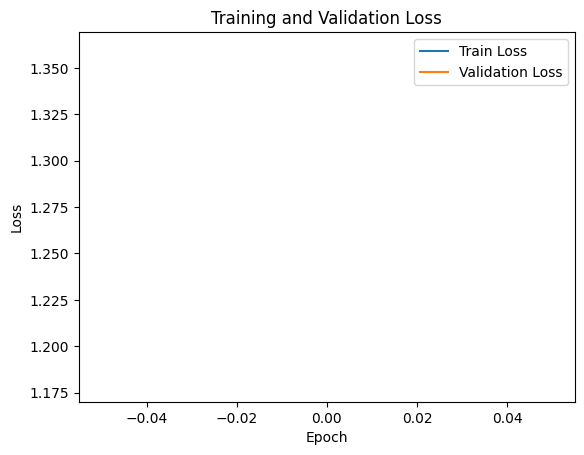

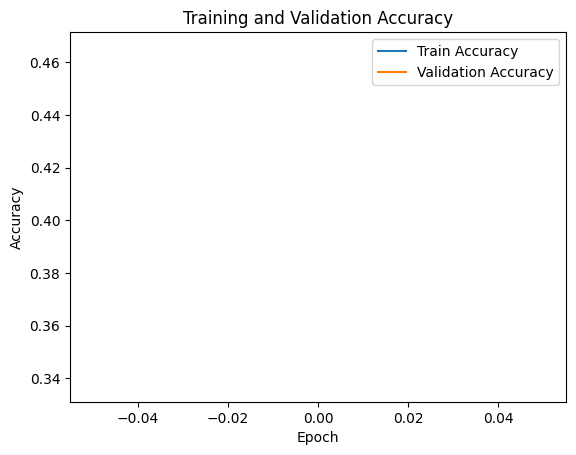

In [5]:
hist = history.history

# plotting time!
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

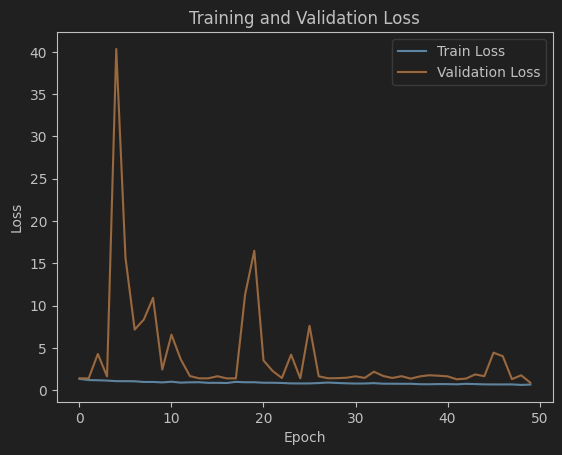

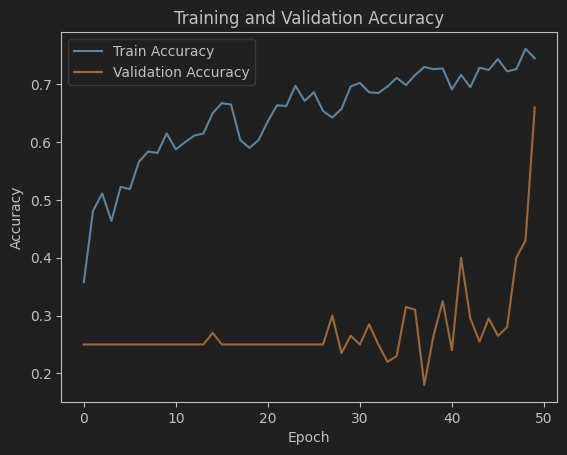

As can be seen, the training data accuracy shows steady growth. However, the validation curve is unstable and spiky near the end.

This means that the model is either overfitting or incorrectly interpreting the data with the pretrained head. Also, the augmentation may be too violent.

I softened the augmentation parameters and also froze the head to avoid overfitting + deleted convolution layers to reduce the amount of parameters and clutter overall. More importantly, I rewrote the classifier from Sequential() to a functional approach. And it worked!
The model really improved.

Old syntax:

    baseline_CNN_model = tf.keras.models.Sequential([ # baseline CNN model (input -> resnet50 -> convolution and max pooling layers -> dense layers with relu and softmax layer.
        InputLayer(input_shape=(224,224,3)), layers.RandomFlip(["horizontal", "vertical"]),

        layers.RandomRotation(0.2), layers.RandomTranslation(0.1, 0.1),

        layers.Lambda(tf.keras.applications.resnet50.preprocess_input, name="resnet_preproc"),
        tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg'),

        layers.Dense(128, activation='relu'), layers.Dropout(0.2),
        layers.Dense(5 if full_dataset_present else 4, activation='softmax')
    ])
    baseline_CNN_model.layers[5].trainable = False

New syntax:

In [6]:
inputs = tf.keras.Input((224,224,3))
x = layers.RandomFlip(["horizontal", "vertical"])(inputs)
x = layers.RandomRotation(0.2)(x)
x = layers.RandomTranslation(0.1, 0.1)(x)
x = tf.keras.applications.resnet50.preprocess_input(x)

resnet = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", pooling="avg"
)
resnet.trainable = False
x = resnet(x, training=False)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5 if full_dataset_present else 4, activation="softmax")(x)
baseline_CNN_model = tf.keras.Model(inputs, outputs)

In [ ]:
from keras.src.callbacks import EarlyStopping

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # Adam optimizer as a superior for this task

baseline_CNN_model.compile( # compilation
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

train_sample, valid_sample = load_data(labels_and_paths_csv_fp_PC_sample, "PC") # data loading (see data_loader.py)

history = baseline_CNN_model.fit( # fitting
    train_sample,
    validation_data=valid_sample,
    epochs=30,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
)

hist = history.history

# plotting time!
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.3150 - loss: 1.4120 - val_accuracy: 0.4950 - val_loss: 1.1768
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4437 - loss: 1.2347 - val_accuracy: 0.5650 - val_loss: 1.0720
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4950 - loss: 1.1335 - val_accuracy: 0.5900 - val_loss: 0.9983
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5700 - loss: 1.0708 - val_accuracy: 0.5950 - val_loss: 0.9579
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5612 - loss: 1.0284 - val_accuracy: 0.6150 - val_loss: 0.9285
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5888 - loss: 0.9969 - val_accuracy: 0.6050 - val_loss: 0.9244
Epoch 7/30
23/25 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5942 - loss: 0.9846

Here are the new graphs:

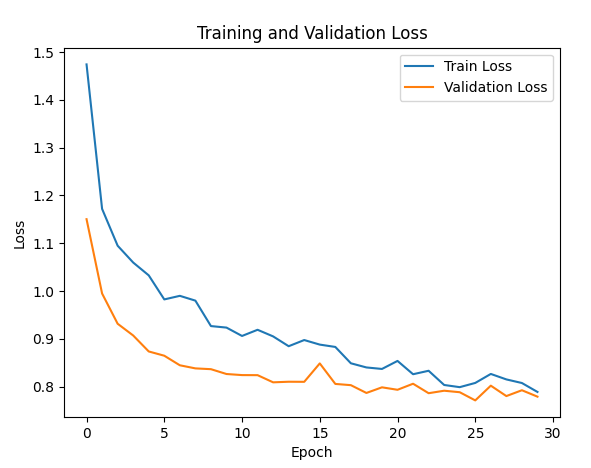

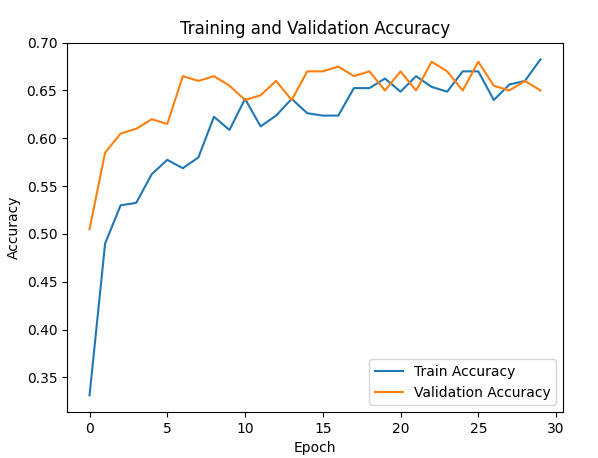

# Evaluation

The baseline classifier managed to get around 0.65 accuracy on the small sample dataset. As for the full dataset:

# 2. Captioner

As for the captioner, I first need to create a description for each image in the dataset. But should I do it by hand? NO! It is impossible to describe more than 200 thousand images, typing by hand.

Instead, let's make use of the features from the dataset that we dropped when building the classifier. If we extract the fractions of voters that selected particular features in a given image, we can add these features in text to the caption! Also, I add some deterministic randomness (selecting the (i % 2) item in a list) for variety.

Here is the caption generator code:

In [ ]:
import pandas as pd

manifest_fp = r"C:\Users\user\PycharmProjects\galaxy_morphology_ml_captioning\data\processed\manifest_train_and_val.csv"

df = pd.read_csv(manifest_fp)

features_column_names = {
    # General features
    "features": "t01_smooth_or_features_a02_features_or_disk_debiased",
    "smooth": "t01_smooth_or_features_a01_smooth_debiased",
    "spiral": "t04_spiral_a08_spiral_debiased",
    "no_spiral": "t04_spiral_a09_no_spiral_debiased",
    "edge_on": "t02_edgeon_a04_yes_debiased",
    "bar": "t03_bar_a06_bar_debiased",
    "rounded/cigar-shaped": "t07_rounded_a18_cigar_shaped_debiased",

    # Bulge features
    "no_bulge": "t05_bulge_prominence_a10_no_bulge_debiased",
    "bulge_just_noticeable": "t05_bulge_prominence_a11_just_noticeable_debiased",
    "bulge_obvious": "t05_bulge_prominence_a12_obvious_debiased",
    "bulge_dominant": "t05_bulge_prominence_a13_dominant_debiased",
    "bulge_rounded": "t09_bulge_shape_a25_rounded_debiased",
    "bulge_boxy": "t09_bulge_shape_a26_boxy_debiased",

    # Odd features
    "odd": "t06_odd_a14_yes_debiased",
    "ring": "t08_odd_feature_a19_ring_debiased",
    "lens_or_arc": "t08_odd_feature_a20_lens_or_arc_debiased",
    "disturbed": "t08_odd_feature_a21_disturbed_debiased",
    "irregular": "t08_odd_feature_a22_irregular_debiased",
    "other_odd": "t08_odd_feature_a23_other_debiased",
    "merger": "t08_odd_feature_a24_merger_debiased",
    "dust_lane": "t08_odd_feature_a38_dust_lane_debiased",

    # Arms winding features
    "winding_tight": "t10_arms_winding_a28_tight_debiased",
    "winding_medium": "t10_arms_winding_a29_medium_debiased",
    "winding_loose": "t10_arms_winding_a30_loose_debiased",

    # Number of arms
    "n_1": "t11_arms_number_a31_1_debiased",
    "n_2": "t11_arms_number_a32_2_debiased",
    "n_3": "t11_arms_number_a33_3_debiased",
    "n_4": "t11_arms_number_a34_4_debiased",
    "n_5+": "t11_arms_number_a36_more_than_4_debiased",
    "n_undefined": "t11_arms_number_a37_cant_tell_debiased",
}

def get_feature_value(row, feature_name):
    return row[feature_name]

captions = pd.DataFrame({"objid": [], "caption": []})

for i in range (df.shape[0]):
    caption = "galaxy"
    if df.iloc[i][features_column_names["irregular"]] >= 0.6:
        caption = "irregular " + caption
    elif df.iloc[i][features_column_names["spiral"]] >= 0.6 or df.iloc[i][features_column_names["features"]] >= df.iloc[i][features_column_names["smooth"]]:
        caption = "spiral " + caption
        if df.iloc[i][features_column_names["winding_tight"]] >= 0.6:
            caption += [" with tightly wound arms,", " with tightly wound spiral arms,"][i % 2]
        elif df.iloc[i][features_column_names["winding_medium"]] >= 0.6:
            caption += [" with moderately wound arms,", " with moderately wound spiral arms,"][i % 2]
        elif df.iloc[i][features_column_names["winding_loose"]] >= 0.6:
            caption += [" with loosely wound arms,", " with loosely wound spiral arms,"][i % 2]
        if df.iloc[i][features_column_names["n_1"]] >= 0.6:
            caption += [" with 1 spiral arm,", " with a single spiral arm,"][i % 2]
        elif df.iloc[i][features_column_names["n_2"]] >= 0.6:
            caption += [" with 2 spiral arms,", " with a pair of spiral arms,"][i % 2]
        elif df.iloc[i][features_column_names["n_3"]] >= 0.6:
            caption += [" with 3 spiral arms,", " with three spiral arms,"][i % 2]
        elif df.iloc[i][features_column_names["n_4"]] >= 0.6:
            caption += [" with 4 spiral arms,", " with four spiral arms,"][i % 2]
        elif df.iloc[i][features_column_names["n_5+"]] >= 0.6:
            caption += [" with more than 5 spiral arms,", " with many spiral arms,"][i % 2]
    elif df.iloc[i][features_column_names["smooth"]] >= 0.6 and df.iloc[i][features_column_names["smooth"]] >= df.iloc[i][features_column_names["features"]]:
        caption = "elliptical " + caption

    if df.iloc[i][features_column_names["merger"]] >= 0.6:
        if i % 2 == 0: caption = "interacting/merging " + caption
        else: caption += " in a merger,"
    if df.iloc[i][features_column_names["edge_on"]] >= 0.6:
        if i % 2 == 0: caption = "edge-on " + caption
        else: caption += " seen edge-on,"
    if df.iloc[i][features_column_names["bar"]] >= 0.6:
        if i % 2 == 0: caption = "barred " + caption
        else: caption += " with a central bar,"
    if df.iloc[i][features_column_names["rounded/cigar-shaped"]] >= 0.6:
        caption = "rounded/cigar-shaped " + caption

    if df.iloc[i][features_column_names["ring"]] >= 0.6:
        caption += [" with a ring,", " with a ring structure,"][i % 2]
    if df.iloc[i][features_column_names["dust_lane"]] >= 0.6:
        caption += [" with a dust lane,", " with dust lanes,"][i % 2]
    if df.iloc[i][features_column_names["disturbed"]] >= 0.6 and "interacting/merging" not in caption:
        caption += [" with disturbed morphology,", " with signs of disturbance,"][i % 2]
    if df.iloc[i][features_column_names["lens_or_arc"]] >= 0.6 and "elliptical" in caption:
        caption += " with a lens/arc feature,"

    if df.iloc[i][features_column_names["no_bulge"]] >= 0.6:
        caption += [" with a small or non-existent", " with a faint or not prominent"][i % 2]
        if df.iloc[i][features_column_names["bulge_rounded"]] >= 0.6:
            caption += [" with a rounded bulge,", " with a round bulge,"][i % 2]
        elif df.iloc[i][features_column_names["bulge_boxy"]] >= 0.6:
            caption += [" with a boxy bulge,", " with a rectangular/boxy bulge,"][i % 2]
        else:
            caption += " bulge,"
    elif df.iloc[i][features_column_names["bulge_just_noticeable"]] >= 0.6:
        caption += [" with a modest", " with a noticeable"][i % 2]
        if df.iloc[i][features_column_names["bulge_rounded"]] >= 0.6:
            caption += [" with a rounded bulge,", " with a round bulge,"][i % 2]
        elif df.iloc[i][features_column_names["bulge_boxy"]] >= 0.6:
            caption += [" with a boxy bulge,", " with a rectangular/boxy bulge,"][i % 2]
        else:
            caption += " bulge,"
    elif df.iloc[i][features_column_names["bulge_obvious"]] >= 0.6:
        caption += [" with a prominent", " with a conspicuous"][i % 2]
        if df.iloc[i][features_column_names["bulge_rounded"]] >= 0.6:
            caption += [" with a rounded bulge,", " with a round bulge,"][i % 2]
        elif df.iloc[i][features_column_names["bulge_boxy"]] >= 0.6:
            caption += [" with a boxy bulge,", " with a rectangular/boxy bulge,"][i % 2]
        else:
            caption += " bulge,"
    elif df.iloc[i][features_column_names["bulge_dominant"]] >= 0.6:
        caption += [" with a dominant", " with a very large"][i % 2]
        if df.iloc[i][features_column_names["bulge_rounded"]] >= 0.6:
            caption += [" with a rounded bulge,", " with a round bulge,"][i % 2]
        elif df.iloc[i][features_column_names["bulge_boxy"]] >= 0.6:
            caption += [" with a boxy bulge,", " with a rectangular/boxy bulge,"][i % 2]
        else:
            caption += " bulge,"

    if caption[-1] == ',': caption = caption[:-1]

    captions.loc[len(captions)] = [df.iloc[i]["objid"], caption]

out = captions

out.to_csv(r"C:\Users\user\PycharmProjects\galaxy_morphology_ml_captioning\data\processed\captions_full.csv", index=False, encoding="utf-8")